In [35]:
# Imports libraries
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Imports 'results' and 'races' as data frames
results = pd.read_csv('f1_archive/results.csv')
races = pd.read_csv('f1_archive/races.csv')
circuits = pd.read_csv('f1_archive/circuits.csv')

# Sets the time span the data will look at
start_year = 2014
end_year = 2021

races = races.drop(races[races['year'] < start_year].index, axis = 0)
races = races.drop(races[races['year'] > end_year].index, axis = 0)
races = races.reset_index().drop(['index'], axis = 1)

races_list = []

for i in races.index:
    races_list.append(races.iloc[i,0])

def raceId_to_year(raceId):
    if raceId in races_list:
        return True
    else: 
        return False

results['check'] = list(map( raceId_to_year, results['raceId']))
results = results.drop(results[results['check'] == False].index, axis = 0)
results = results.drop(['check'], axis = 1)

In [3]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3266 entries, 22127 to 25398
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resultId         3266 non-null   int64  
 1   raceId           3266 non-null   int64  
 2   driverId         3266 non-null   int64  
 3   constructorId    3266 non-null   int64  
 4   number           3266 non-null   object 
 5   grid             3266 non-null   int64  
 6   position         3266 non-null   object 
 7   positionText     3266 non-null   object 
 8   positionOrder    3266 non-null   int64  
 9   points           3266 non-null   float64
 10  laps             3266 non-null   int64  
 11  time             3266 non-null   object 
 12  milliseconds     3266 non-null   object 
 13  fastestLap       3266 non-null   object 
 14  rank             3266 non-null   object 
 15  fastestLapTime   3266 non-null   object 
 16  fastestLapSpeed  3266 non-null   object 
 17  statusId 

In [4]:
# Adds columns containing all the info needed to find the results on formula1.com
races = races.sort_values(by = ['date'])

starting_value_dict = {2021: 1064,
                       2020: 1045,
                       2019: 1000,
                       2018: 979,
                       2017: 959,
                       2016: 938,
                       2015: 917,
                       2014: 898}

races['f1Number'] = 0

for i in races.index:
    races.iloc[i,8] = starting_value_dict[races.iloc[i,1]] + races.iloc[i,2] -1
    
def find_name(id):
    name = circuits[circuits['circuitId'] == id].country.values[0].lower()
    if ' ' in name:
        return name.replace(' ', '-')
    else:
        return name

races['f1Name'] = list(map(find_name,races['circuitId']))

# Handles Exceptions from 2014 - 2021
for i in races.index:
    if races.iloc[i,0] == 918:
        races.iloc[i,8] = 916
        races.iloc[i,9] = 'abu-dhabi'
    elif races.iloc[i,0] == 936:
        races.iloc[i,8] = 925
        races.iloc[i,9] = 'great-britain'
    elif races.iloc[i,0] == 1051:
        races.iloc[i,8] = 1105
    elif races.iloc[i,0] == 1055:
        races.iloc[i,8] = 1086
    elif races.iloc[i,0] >= 1056:
        races.iloc[i,8] = races.iloc[i,8]-1
        
        if races.iloc[i,0] == 1059:
            races.iloc[i,8] = 1070
        elif races.iloc[i,0] >= 1069:
            races.iloc[i,8] = races.iloc[i,8]+23

races = races.drop(races[races['raceId'] == 1041].index, axis = 0)
            
races.tail(3)

,raceId,year,round,circuitId,name,date,time,url,f1Number,f1Name
140,1051,2021,20,78,Qatar Grand Prix,2021-11-21,14:00:00,http://en.wikipedia.org/wiki/2021_Qatar_Grand_...,1105,qatar
158,1072,2021,21,77,Saudi Arabian Grand Prix,2021-12-05,17:30:00,http://en.wikipedia.org/wiki/2021_Saudi_Arabia...,1106,saudi-arabia
159,1073,2021,22,24,Abu Dhabi Grand Prix,2021-12-12,13:00:00,http://en.wikipedia.org/wiki/2021_Abu_Dhabi_Gr...,1107,uae


In [5]:
# Finds FP1 Result Data
fp1_results_dict = {}

for ids in races['raceId']:
    race_info = races[races['raceId'] == ids]
    link = 'https://www.formula1.com/en/results.html/' + str(race_info.year.values[0]) + '/races/' + str(race_info.f1Number.values[0]) + '/' + race_info.f1Name.values[0] + '/practice-1.html'
    fp1_results_dict[ids] = pd.read_html(link)[0]
    
# Finds Results where the data was not properly aquired
for ids in races['raceId']:  
    if fp1_results_dict[ids].shape[1] != 9:
        print(ids, 'WAS NOT FOUND')
        
# Assigns the data to results tables
results = results.reset_index().drop(['index'], axis = 1)
results['fp1Pos'] = 0
results['fp1Laps'] = 0
width = results.shape[1]

for i in results.index:
    try:
        number = int(results.iloc[i,4])
        raceId = results.iloc[i,1]
        df = fp1_results_dict[raceId]
        df = df.drop(df[df['No'] != number].index, axis = 0)
        fp1Pos = df.iloc[:,1].values[0]
        fp1Laps = df.iloc[:,7].values[0]
    except:
        fp1Pos = -1
        fp1Laps = -1
        
    results.iloc[i, width-2] = fp1Pos
    results.iloc[i, width-1] = fp1Laps
    
results.head(3)

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,fp1Pos,fp1Laps
0,22130,900,3,131,6,3,1,1,1,25.0,57,1:32:58.710,5578710,19,1,1:32.478,206.436,1,6,17
1,22131,900,825,1,20,4,2,2,2,18.0,57,+26.777,5605487,49,6,1:33.066,205.131,1,8,28
2,22132,900,18,1,22,10,3,3,3,15.0,57,+30.027,5608737,39,5,1:32.917,205.460,1,2,23


In [6]:
# Finds FP1 Result Data
fp2_results_dict = {}

for ids in races['raceId']:
    race_info = races[races['raceId'] == ids]
    link = 'https://www.formula1.com/en/results.html/' + str(race_info.year.values[0]) + '/races/' + str(race_info.f1Number.values[0]) + '/' + race_info.f1Name.values[0] + '/practice-2.html'
    fp2_results_dict[ids] = pd.read_html(link)[0]
    
# Finds Results where the data was not properly aquired
for ids in races['raceId']:  
    if fp2_results_dict[ids].shape[1] != 9:
        print(ids, 'WAS NOT FOUND')
        
# Assigns the data to results tables
results = results.reset_index().drop(['index'], axis = 1)
results['fp2Pos'] = 0
results['fp2Laps'] = 0
width = results.shape[1]

for i in results.index:
    try:
        number = int(results.iloc[i,4])
        raceId = results.iloc[i,1]
        df = fp2_results_dict[raceId]
        df = df.drop(df[df['No'] != number].index, axis = 0)
        fp2Pos = df.iloc[:,1].values[0]
        fp2Laps = df.iloc[:,7].values[0]
    except:
        fp2Pos = -1
        fp2Laps = -1
        
    results.iloc[i, width-2] = fp2Pos
    results.iloc[i, width-1] = fp2Laps
    
results.head(3)

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,fp1Pos,fp1Laps,fp2Pos,fp2Laps
0,22130,900,3,131,6,3,1,1,1,25.0,...,5578710,19,1,1:32.478,206.436,1,6,17,2,31
1,22131,900,825,1,20,4,2,2,2,18.0,...,5605487,49,6,1:33.066,205.131,1,8,28,9,34
2,22132,900,18,1,22,10,3,3,3,15.0,...,5608737,39,5,1:32.917,205.460,1,2,23,5,33


In [8]:
# Exports Results as .csv
results.to_csv('f1_archive/full_results_post_2014.csv')

This plot show the relationship between fp1Pos and the number of points scored
The coeficient is: -0.5754119610168764
The p-value is: 1.4580323025515027e-268



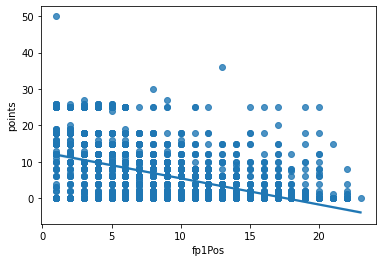

In [42]:
# Just for fun, here is some analysis of that data
for i in range(18,22):
    results = results.drop(results[results.iloc[:,i] == -1].index, axis = 0)

def plot_v_points(x_vals):
    sns.regplot(x = x_vals, 
                y = 'points', 
                data = results)
    plt.ylim = (0,)
    
    cf, pv = stats.pearsonr(results[x_vals], results['points'])
    print('This plot show the relationship between', x_vals, 'and the number of points scored')
    print('The coeficient is:', cf)
    print('The p-value is:', pv)
    print('')

plot_v_points('fp1Pos')

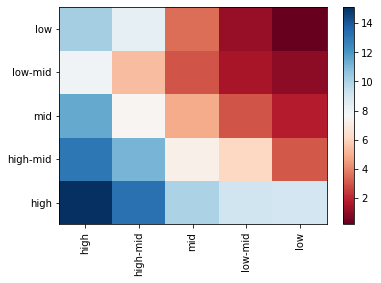

In [37]:
# Creates a heat map showing the relation ship between where drives finis in both practice sessions,
# and how many points they score in the race
fp1_bins = [0, 3, 5, 10, 15, max(results['fp1Pos'])]
fp2_bins = [0, 3, 5, 10, 15, max(results['fp2Pos'])]
bin_names = ['high', 'high-mid', 'mid', 'low-mid', 'low',]

results['fp1PosBins'] = pd.cut(results['fp1Pos'], fp1_bins, labels = bin_names, include_lowest = True)
results['fp2PosBins'] = pd.cut(results['fp2Pos'], fp2_bins, labels = bin_names, include_lowest = True)

practice_results = results[['fp1PosBins', 'fp2PosBins', 'points']]
practice_results_pivot = practice_results.groupby(['fp1PosBins', 'fp2PosBins'], as_index = False).mean()
practice_results_pivot = practice_results_pivot.pivot(index = 'fp1PosBins', columns = 'fp2PosBins')

fig, ax = plt.subplots()
im = ax.pcolor(practice_results_pivot, cmap='RdBu')

#label names
row_labels = practice_results_pivot.columns.levels[1]
col_labels = practice_results_pivot.index

#move ticks and labels to the center
ax.set_xticks(np.arange(practice_results_pivot.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(practice_results_pivot.shape[0]) + 0.5, minor=False)

#insert labels
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(col_labels, minor=False)

#rotate label if too long
plt.xticks(rotation=90)

fig.colorbar(im)
plt.show()